<a href="https://colab.research.google.com/github/DSills735/WGU-Capstone-MLB-Homerun-Predictor/blob/main/WGU_CS_Capstone_Sills.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to my capstone project for the WGU Computer Science program.
Please, while using my project, follow my comments at the top of each code block as instructions on intended use of this ML implementation.
My comments will describe what is happening, and the purpose of each section in simple terms.
Some general guidelines about this implementation:


1.   If a section states to run this section in green text at the top of the code, press the play button in the top left corner of the cell. It is of the utmost importance that all blocks are ran in order from top to bottom.

2.   Reading the green text will often give insight into what the code does at that point, allowing those who do not understand python to understand this implementation.
3. It is important that these code blocks are ran in order. Please follow them as they guide you. This will prevent unnecessary errors in the later blocks, and ensure accurate data when generating the visuals.
4. Blocks will be numbered in the top left corner for ease of use.

In [29]:
#1. Begin. These are just import statements for the python, these are used for bringing in all of the needed libraries for this implementation.
#Run this section of code.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importing sklearn, which will help me implement the Logisitic Regression and LinearRegression ML model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

In [2]:
#2. This section will read in the dataset that I have dowloaded and cleaned from Baseball Savant search.
#This Dataset is all of the batted balls in play in the 2024 MLB Regular Season (no playoffs, or spring training)
#this is reading the CSV file containing my dataset, and cleaning it up for any rows that might not have data.


#Run this section of code.

url = 'https://raw.githubusercontent.com/DSills735/WGU-Capstone-MLB-Homerun-Predictor/main/Savant_Ball_In_Play_Data.csv'
bip = pd.read_csv(url)
bip = bip.dropna(subset=['exit_velocity', 'launch_angle', 'pitch_speed', 'park_name', 'hit_distance_sc', 'outcome'])

#this line will search the outcome line for the home run outcome. it then creates a new datapoint that is binary in nature. 1 if homerun, 0 if not.
bip['home_run'] = (bip['outcome'] == 'home_run').astype(int)
#this line was added later, as when I was calculating batted ball distance it was skewing substantially low. This is a list of only balls with outcome 'home_run'
homeruns_only = bip[bip['outcome'] == 'home_run'].copy()

<ipython-input-2-5122e9e5a9a5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bip['home_run'] = (bip['outcome'] == 'home_run').astype(int)


In [3]:
#3. This will intitialize the park so the algorithm can keep track in the future if a homerun was hit there or not.
#After this, the arguments used for input are defined, and the park_name dummies created in the first lines are placed into a list

#Run this section of code.
bip = pd.get_dummies(bip, columns=['park_name'])

input_args = ['exit_velocity', 'launch_angle', 'pitch_speed']
parks_column = [col for col in bip.columns if col.startswith('park_name_')]


In [31]:
#4. It should be noted, this area was not in my original plan. I have added it later as some added detail which will be further described
#in the written portion of this submission.
#aligning with my addition of homeruns_only, I am only calculating distance of batted balls based on homerun balls.
#this trains the linear regression model to determine hit histance for the later projection in output.

#Run this section of code.
x_dist = homeruns_only[input_args]
y_dist = homeruns_only['hit_distance_sc']

x_dist_train, x_dist_test, y_dist_train, y_dist_test = train_test_split(x_dist, y_dist, test_size=0.2, random_state = 5)

#calls the linear regression function imported in step 1.

dist_model = LinearRegression()
dist_model.fit(x_dist_train, y_dist_train)

LinearRegression()

In [40]:
#5. This section ios essentially going to operate the same as above, but it will be training the Logistic Regression.
#This is to determine if a batted ball will be a homer.

#Run this section of code. Please note this might take up to 10-15 seconds to run.
x_homer = bip[input_args + parks_column]
y_homer = bip['home_run']

x_homer_train, x_homer_test, y_homer_train, y_homer_test = train_test_split(x_homer, y_homer, test_size = .15, random_state = 5)

homers = LogisticRegression(max_iter = 1500)
homers.fit(x_homer_train, y_homer_train)

LogisticRegression(max_iter=1500)

In [42]:
#6. Section is where we combine all of what we have done through the previous blocks, and allow us to use the data for prediction.
#This section will ask for three different user inputs. Exit Velocity, Launch Angle, and Pitch Speed. These are the arguments (input_args) from
#above that will be used to test to see if a ball is a homerun or not.

#Run this section of code. There will be 3 requested inputs that you can find below the block of code. When finished that is where your output will be as well.
exit_velocity = float(input('Enter exit velocity in MPH. Ex. 97.5: '))
launch_angle = float(input('Enter launch angle in degrees, can be negative. Ex. 27.6: '))
pitch_speed = float(input('Enter pitch speed in MPH. Ex. 93.4: '))

all_probabilities = []
def predictions(exit_velocity, launch_angle, pitch_speed):

  #projected the distance of a batted ball
  feature_names_dist = pd.DataFrame([{
      'exit_velocity': exit_velocity,
      'launch_angle' : launch_angle,
      'pitch_speed': pitch_speed
  }])
  hit_distance = dist_model.predict(feature_names_dist)[0]
  print()
  print(f'Projected distance: {int(hit_distance)}ft')

  #homerun projection and output
  homerun_in = []
  not_homerun_in = []
  args = ['exit_velocity', 'launch_angle', 'pitch_speed']

#this will compare to all stadiums and print a list if it thinks it has higher than a 20% chance to be a homerun.
  for stadium in parks_column:
    park_vector = [0]*len(parks_column)
    park_index = parks_column.index(stadium)
    park_vector[park_index] = 1

    inputs = dict(zip(args + parks_column, [exit_velocity, launch_angle, pitch_speed] + park_vector))
    feature_names_input = pd.DataFrame([inputs])
    probability_of_homerun = homers.predict_proba(feature_names_input)[0][1]
    all_probabilities.append(probability_of_homerun)
    real_stadium_name = stadium.replace('park_name_', '')
    if probability_of_homerun >= 0.2:
      homerun_in.append(real_stadium_name)
    else:
      not_homerun_in.append(real_stadium_name)

  print('Homerun at:')
  print()
  for stadium in homerun_in:
    print(stadium)
  print()
  print('Not a homerun at:')
  print()
  for stadium in not_homerun_in:
    print(stadium)
  print()
  print(f'This is a homerun in {len(homerun_in)} out of 30 ballparks!')


predictions(exit_velocity, launch_angle, pitch_speed)




Enter exit velocity in MPH. Ex. 97.5: 104.5
Enter launch angle in degrees, can be negative. Ex. 27.6: 29
Enter pitch speed in MPH. Ex. 93.4: 89

Projected distance: 399ft
Homerun at:

American Family Field
Angel Stadium
Busch Stadium
Chase Field
Citi Field
Citizens Bank Park
Comerica Park
Coors Field
Daikin Park
Dodger Stadium
Fenway Park
Globe Life Field
Great American Ball Park
Kauffman Stadium
Nationals Park
Oakland Coliseum
Oracle Park
Oriole Park at Camden Yards
Petco Park
Progressive Field
Rate Field
Rogers Centre
T-Mobile Park
Target Field
Tropicana Field
Wrigley Field
Yankee Stadium
loanDepot park

Not a homerun at:

PNC Park
Truist Park

This is a homerun in 28 out of 30 ballparks!


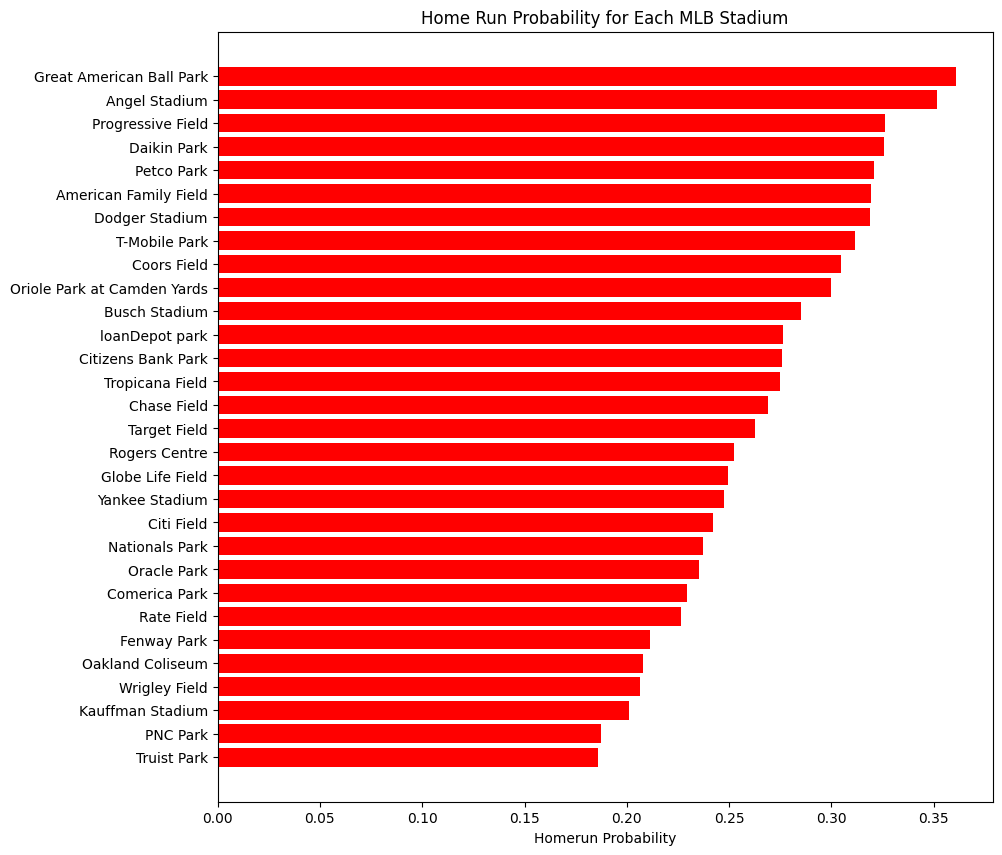

In [43]:
#7. This frame will generate a visualization of the probability for a homerun at each stadium, based on the metrics input.

#Run this section of code. Below you will see the probability the input metrics return a homerun in every stadium represented by a bar graph.
probability = pd.DataFrame({
    'Stadium': [stadium.replace('park_name_', '') for stadium in parks_column],
    'Homerun Probability': all_probabilities
}).sort_values(by='Homerun Probability', ascending = True)


plt.figure(figsize=(10, 10))
plt.barh(probability['Stadium'], probability['Homerun Probability'], color = 'red')
plt.title('Home Run Probability for Each MLB Stadium')
plt.xlabel('Homerun Probability')
plt.show()

<ipython-input-8-8de6a3516cbd>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_homerun_distance.values, y=average_homerun_distance.index, palette='coolwarm')


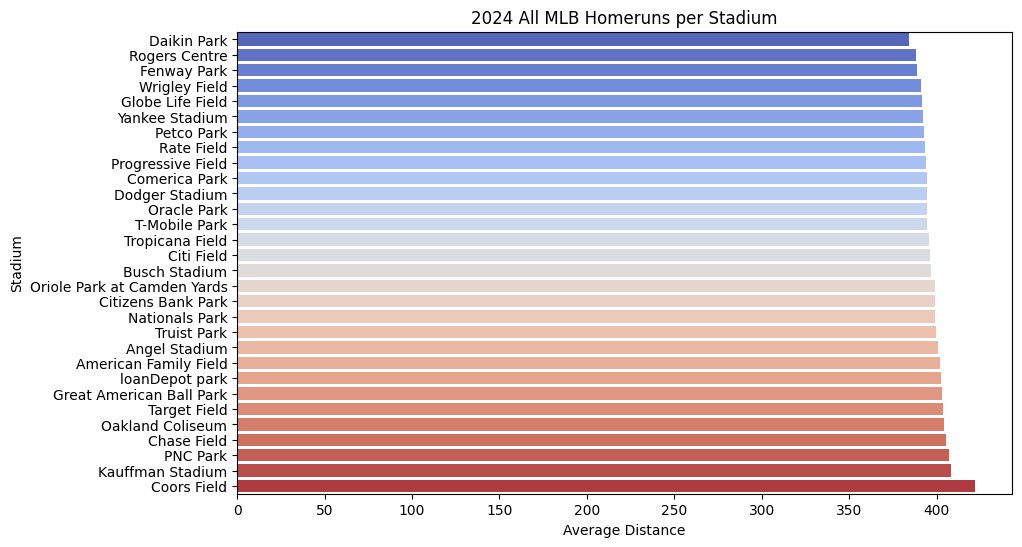

In [8]:
#8. another visualization generated. This one is to show the average distance of a homerun based on ballpark.

#Run this section of code. Below you will see a barplot generated based on the subset of data I created based only on homeruns in 2024.
average_homerun_distance = homeruns_only.groupby('park_name')['hit_distance_sc'].mean().sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=average_homerun_distance.values, y=average_homerun_distance.index, palette='coolwarm')
plt.title('2024 All MLB Homeruns per Stadium')
plt.xlabel('Average Distance')
plt.ylabel('Stadium')
plt.show()


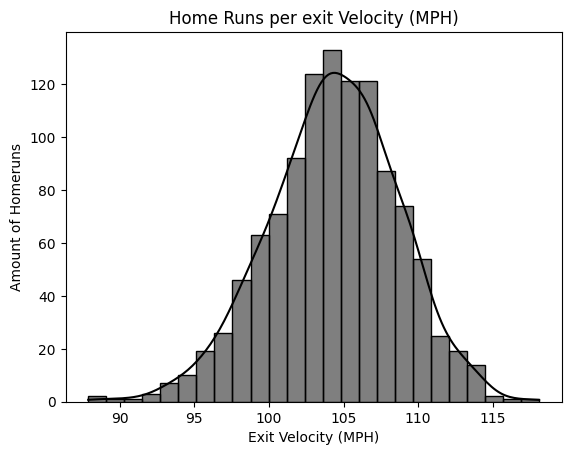

In [9]:
#9. another visual here. This one shows the amount of homeruns, per exit velocity using the 2024 homeruns only subset.

#Run this section of code. Below a histogram t will be generated showing the number of homeruns in relation to exit velocity.
plt.figsize=(10, 8)
sns.histplot(homeruns_only['exit_velocity'], bins = 25, kde = True, color = 'black')
plt.title('Home Runs per exit Velocity (MPH)')
plt.xlabel('Exit Velocity (MPH)')
plt.ylabel('Amount of Homeruns')

plt.show()

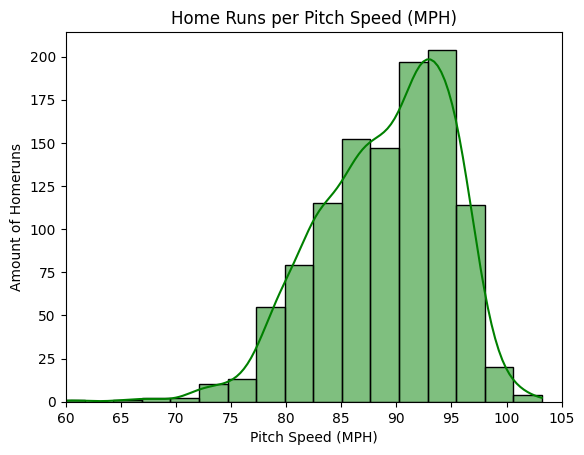

In [10]:
#10. Using the same implementation as the graph above, this shows the number of homeruns based on pitch speed.

#Run this section of code. You will see another graph, showing home runs in relation to pitch speed.
plt.figsize=(10, 8)
sns.histplot(homeruns_only['pitch_speed'], bins = 25, kde = True, color = 'green')
plt.xlim(60,105)
plt.title('Home Runs per Pitch Speed (MPH)')
plt.xlabel('Pitch Speed (MPH)')
plt.ylabel('Amount of Homeruns')

plt.show()

Below this are my testing methods. These do not need to be ran while following the user guide. The user guide ends at the above graph.

In [33]:
#linear regression testing

predict = dist_model.predict(x_dist_test)
mean_error = mean_absolute_error(y_dist_test, predict)
r_score = r2_score(y_dist_test, predict)

print(f'Mean Absolute Error: {mean_error:.1f}ft')
print(f'R2 Score: {r_score:.2f}')

Mean Absolute Error: 14.8ft
R2 Score: 0.38


In [41]:
#logistic regression tests

homerun_predict = homers.predict(x_homer_test)
accuracy = accuracy_score(y_homer_test, homerun_predict)
precise = precision_score(y_homer_test, homerun_predict)
recall = recall_score(y_homer_test, homerun_predict)
f_score = f1_score(y_homer_test, homerun_predict)

print(f'Homerun prediciton accuracy: {accuracy:.1f}')
print(f'Precision Score: {precise:.2f}')
print(f'Recall Score: {recall:.2f}')
print(f'F1 Score: {f_score:.2f}')

Homerun prediciton accuracy: 1.0
Precision Score: 0.66
Recall Score: 0.24
F1 Score: 0.35
